https://huggingface.co/keremberke/yolov8m-chest-xray-classification

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Define the data directories
normal_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Normal'
hemorrhage_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Hemorrhage'
# Get the list of all the images
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
hemorrhage_images = [os.path.join(hemorrhage_dir, img) for img in os.listdir(hemorrhage_dir)]
# Create labels
normal_labels = [0]*len(normal_images)  # let's assume 0 for normal
hemorrhage_labels = [1]*len(hemorrhage_images)  # and 1 for hemorrhage

# Concatenate data and labels
images = normal_images + hemorrhage_images
labels = normal_labels + hemorrhage_labels


In [3]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

PyTorch uses a Dataset object, which is an abstract class representing a dataset, and a DataLoader, which wraps an iterable around the Dataset. Here's how you can create a custom Dataset for your images:

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import albumentations as albu
from albumentations.pytorch import ToTensorV2

HFLIP = 'T'  # Or 'F', based on your requirement
HFLIPVAL = 1.0 if HFLIP == 'T' else 0.0

class BrainCTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            # Since albumentations requires numpy arrays, convert the image to a numpy array first
            image_np = np.array(image)
            augmented = self.transform(image=image_np)
            image = augmented['image']

        return image, label

# Transformations using albumentations
data_transforms = {
    'train': albu.Compose([
        albu.RandomResizedCrop(height=224, width=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333), p=1.0),
        albu.HorizontalFlip(p=0.5),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'val': albu.Compose([
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.HorizontalFlip(p=HFLIPVAL),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
}

# Create the datasets
train_dataset = BrainCTDataset(train_images, train_labels, transform=data_transforms['train'])
val_dataset = BrainCTDataset(val_images, val_labels, transform=data_transforms['val'])

# Create the dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32,shuffle=True, ),  # num_workers=4 for higher worker we can use os.cpu_count()
    'valid': DataLoader(val_dataset, batch_size=32,shuffle=False,),
}

Training Images:


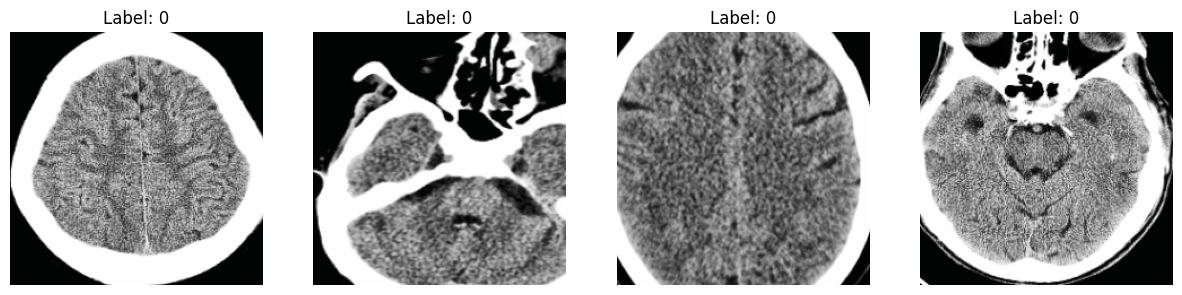

Validation Images:


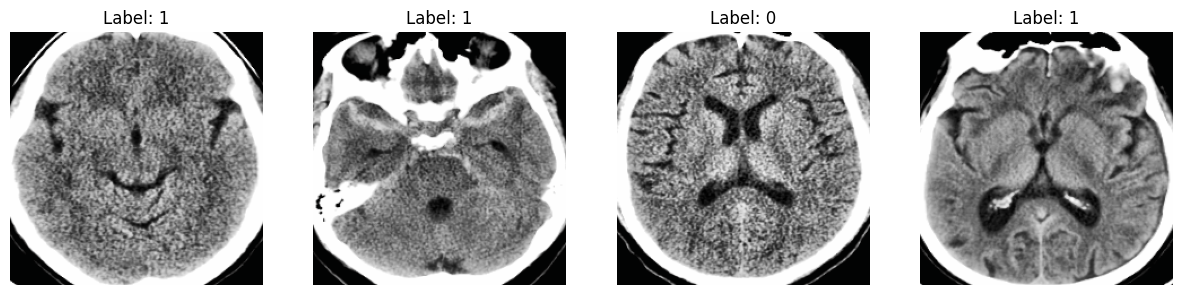

In [5]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

# Visualize random images from training dataset
print("Training Images:")
visualize_random_images(dataloaders['train'])

# Visualize random images from validation dataset
print("Validation Images:")
visualize_random_images(dataloaders['valid'])


## feature extraction HugginFace pre-trained model


In [6]:
from transformers import AutoConfig, AutoModel
from ultralyticsplus import YOLO, postprocess_classify_output


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Load configuration and model

# load model
yolo_model = YOLO('keremberke/yolov8m-chest-xray-classification')


yolo_model.model

c:\Users\moheb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


ClassificationModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
  

In [7]:
# 1. Calculate the total number of parameters
total_params = sum(p.numel() for p in yolo_model.model.parameters())

# 2. Multiply by 4 to get the size in bytes
total_size_bytes = total_params * 4

# 3. Convert bytes to megabytes
total_size_megabytes = total_size_bytes / (1024 * 1024)  # bytes to MB

print(f"Size of the model: {total_size_megabytes:.2f} MB")


Size of the model: 60.18 MB


In [37]:
for name, module in yolo_model.model.named_children():
    print(name, module)


model Sequential(
  (0): Conv(
    (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
  (2): C2f(
    (cv1): Conv(
      (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0-1): 2 x Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
    )
  )
  (3): Conv(
    (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inpl

In [56]:
class ModifiedYolosModel(nn.Module):
    def __init__(self, yolo_model):
        super(ModifiedYolosModel, self).__init__()
        
        # Extract all the children layers
        layers = list(yolo_model.model.children())
        actual_layers = list(layers[0].children())

        # Remove the last layer (the classifier)
        actual_layers = actual_layers[:-1]

        # Add a Flatten layer
        actual_layers.append(nn.Flatten())
        
        # Calculate the flattened size
        flattened_size = 768 * 7 * 7
        # Add the new classifier
        self.classifier = nn.Linear(flattened_size, 2)
        actual_layers.append(self.classifier)

        # Combine the layers into a sequential model
        self.yolo_model = nn.Sequential(*actual_layers)

    def forward(self, x):
        return self.yolo_model(x)  # The output here will be after the classifier


# Usage
model = ModifiedYolosModel(yolo_model).to(device)


In [57]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                        Param #
ModifiedYolosModel                            --
├─Linear: 1-1                                 75,266
├─Sequential: 1-2                             75,266
│    └─Conv: 2-1                              --
│    │    └─Conv2d: 3-1                       (1,344)
│    │    └─SiLU: 3-2                         --
│    └─Conv: 2-2                              --
│    │    └─Conv2d: 3-3                       (41,568)
│    │    └─SiLU: 3-4                         --
│    └─C2f: 2-3                               --
│    │    └─Conv: 3-5                         (9,312)
│    │    └─Conv: 3-6                         (18,528)
│    │    └─ModuleList: 3-7                   (83,136)
│    └─Conv: 2-4                              --
│    │    └─Conv2d: 3-8                       (166,080)
│    │    └─SiLU: 3-9                         --
│    └─C2f: 2-5                               --
│    │    └─Conv: 3-10                        (37,056)
│    │    └─Con

In [58]:
# Using only the feature-extraction part of the model
feature_extractor = nn.Sequential(*list(model.yolo_model.children())[:-2])  # Exclude the Flatten and classifier layers
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # assuming 3x224x224 is the input shape
output = feature_extractor(dummy_input)
print(output.shape)


torch.Size([1, 768, 7, 7])


In [59]:
import time
import copy
from tqdm.auto import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Here we will save the metrics
    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    dataset_sizes = {
        'train': len(train_dataset),
        'valid': len(val_dataset)
    }

    for epoch in tqdm(range(1, num_epochs+1), desc="Epochs"):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} epoch {epoch}", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train|
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Store the loss and accuracy values
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [61]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=10)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


train Loss: 2.2462 Acc: 0.5569


Epochs:  10%|█         | 1/10 [00:17<02:35, 17.25s/it]

valid Loss: 2.2208 Acc: 0.5634

Epoch 2/10
----------


train Loss: 2.1524 Acc: 0.5527


Epochs:  20%|██        | 2/10 [00:34<02:16, 17.12s/it]

valid Loss: 1.6754 Acc: 0.5701

Epoch 3/10
----------


train Loss: 2.0381 Acc: 0.5624


Epochs:  30%|███       | 3/10 [00:51<01:59, 17.13s/it]

valid Loss: 1.9180 Acc: 0.5903

Epoch 4/10
----------


train Loss: 2.3021 Acc: 0.5594


Epochs:  40%|████      | 4/10 [01:09<01:45, 17.54s/it]

valid Loss: 2.4671 Acc: 0.5399

Epoch 5/10
----------


train Loss: 2.1347 Acc: 0.5691


Epochs:  50%|█████     | 5/10 [01:26<01:26, 17.30s/it]

valid Loss: 2.8797 Acc: 0.5877

Epoch 6/10
----------


train Loss: 2.3332 Acc: 0.5775


Epochs:  60%|██████    | 6/10 [01:46<01:12, 18.07s/it]

valid Loss: 2.4135 Acc: 0.6012

Epoch 7/10
----------


train Loss: 2.0773 Acc: 0.5699


Epochs:  70%|███████   | 7/10 [02:04<00:54, 18.27s/it]

valid Loss: 1.9705 Acc: 0.6205

Epoch 8/10
----------


train Loss: 2.3767 Acc: 0.5636


Epochs:  80%|████████  | 8/10 [02:24<00:37, 18.77s/it]

valid Loss: 3.2135 Acc: 0.5861

Epoch 9/10
----------


train Loss: 2.1499 Acc: 0.5577


Epochs:  90%|█████████ | 9/10 [02:44<00:19, 19.04s/it]

valid Loss: 3.5681 Acc: 0.5911

Epoch 10/10
----------


train Loss: 2.0699 Acc: 0.5689


Epochs: 100%|██████████| 10/10 [03:01<00:00, 18.10s/it]

valid Loss: 2.0351 Acc: 0.6465

Training complete in 3m 1s
Best valid accuracy: 0.646516


In [62]:
# Switch to evaluation mode
model.eval()

# Initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat)

# Compute the classification report
from sklearn.metrics import classification_report
class_report=classification_report(lbllist.numpy(), predlist.numpy())
print('Classification Report')
print('-'*20)
print(class_report)


Confusion Matrix
----------------
[[548 135]
 [286 222]]
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       683
           1       0.62      0.44      0.51       508

    accuracy                           0.65      1191
   macro avg       0.64      0.62      0.62      1191
weighted avg       0.64      0.65      0.63      1191



In [63]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # plot training and validation accuracy values
    ax1.plot(history['train_acc'], label='Train')
    ax1.plot(history['valid_acc'], label='Validation')
    ax1.set_title("Model accuracy")
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # plot training and validation loss values
    ax2.plot(history['train_loss'], label='Train')
    ax2.plot(history['valid_loss'], label='Validation')
    ax2.set_title("Model loss")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

C:\Users\moheb\AppData\Local\Temp\ipykernel_30964\2846051292.py:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [18]:
model.state_dict()

OrderedDict([('vit_model.embeddings.cls_token',
              tensor([[[-1.2465e-03,  6.8685e-03, -2.4676e-01,  4.5031e-03,  3.7448e-01,
                         4.6176e-02, -1.1949e-02,  1.0573e-02,  3.2408e-02, -2.0627e-01,
                        -6.7369e-03, -7.5728e-03, -7.6493e-03, -1.0251e-02, -1.2926e-02,
                        -6.4564e-03,  5.2718e-04,  6.4477e-02,  3.1068e-02, -3.8105e-03,
                        -5.4308e-02, -2.8734e-03, -2.5955e-03, -1.8412e-02, -2.3485e-04,
                         5.2871e-02,  3.7488e-03, -1.2328e-02,  3.9768e-02, -3.0639e-02,
                        -4.6675e-04,  1.9472e-02, -1.6957e-02,  1.1188e-02,  2.2552e-02,
                        -7.3993e-04,  4.5310e-02,  2.4576e-03,  1.5185e-03,  8.4335e-03,
                         4.8863e-03,  1.0251e-02,  1.8046e-02,  3.3184e-03,  6.2685e-02,
                         4.0503e-01, -2.6185e-03,  1.1029e-02,  2.5073e-02, -2.1352e-03,
                        -9.1695e-03, -4.9829e-02,  4.9247e-03,